## Machine Learning code to calculate screen time of different movie characters from a video using VGG16 model

## *Import Libraries*
### We will need following libraries
    ### - OpenCV
    ### - Keras
    ### - Pandas
    ### - Numpy
    ### - Matplotlib
    ### - Skimage
    ### - Math
    ### - sklearn

In [55]:
import cv2
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
from keras.utils import np_utils
from keras.applications.vgg16 import preprocess_input
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

### Read the video file
### Find out the fps of the video and capture frames from video at that fps and then save those images

In [24]:
#Set file name
VDO_FL_Name = "Tom and jerry.mp4"
#capture the file
Tom_and_Jerry_VDO_FL = cv2.VideoCapture(VDO_FL_Name)
#get the fps
FrameRate= Tom_and_Jerry_VDO_FL.get(cv2.CAP_PROP_FPS)
print("video fps",framerate)
count =0
x=1
while(Tom_and_Jerry_VDO_FL.isOpened()):
    FrameID=Tom_and_Jerry_VDO_FL.get(cv2.CAP_PROP_POS_FRAMES)
    #read the next frame
    ret,frame = Tom_and_Jerry_VDO_FL.read()
    #break at end of the file
    if(ret != True):
            break
    #save the frame as iamge file
    if(FrameID % math.floor(FrameRate) == 0):
            #save the image as frame number jpg file
            filename = "frame%d.jpg"%count;count+=1
            cv2.imwrite(filename,frame)
#close the file
Tom_and_Jerry_VDO_FL.release()
print("total number of images saved",count)


video fps 8912.0
total number of frames saved 298


### load the labeled file to map each training set into three classes -
    - Neither Tom nor Jerry - Class 0
    - Jerry - Class 1
    - Tom - Class 2
### map the training set with their corresponding class

In [25]:
# read the mapping label data
mapping = pd.read_csv("mapping.csv")
mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
Image_ID    298 non-null object
Class       298 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


In [105]:
mapping.head(12)

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2
5,frame5.jpg,2
6,frame6.jpg,2
7,frame7.jpg,2
8,frame8.jpg,2
9,frame9.jpg,2


image size is: (298, 720, 1280, 3)


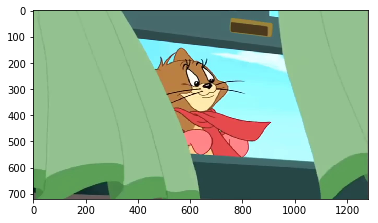

In [109]:
#store images in an array
images =[]
for img_name in mapping.Image_ID:
    img=plt.imread(''+img_name)
    images.append(img)
images = np.array(images)
print("image size is:", images.shape)
#check the 1st image
plt.imshow(images[0])
    

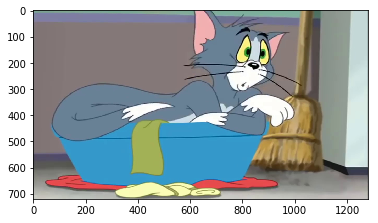

In [107]:
plt.imshow(images[2])


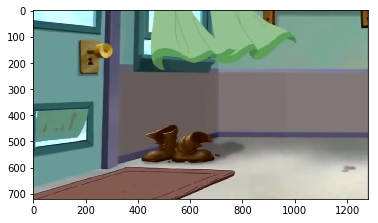

In [110]:
plt.imshow(images[11])

In [40]:
# convert image classes into categorial variables
img_calss = mapping.Class
dummy_img_class = np_utils.to_categorical(img_calss)
dummy_img_class.shape

(298, 3)

### reshaping images to 224x224x3 to use models like VGG16

C:\Users\alok_\Anaconda\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\alok_\Anaconda\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


updated iamge size is: (298, 224, 224, 3)


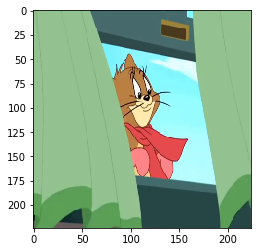

In [48]:
img=[]
for i in range(0,images.shape[0]):
    a = resize(images[i],preserve_range=True,output_shape=(224,224)).astype(int)
    img.append(a)
images=np.array(img)
print("updated iamge size is:",images.shape)
#check the 1st image
plt.imshow(images[0])

In [53]:
#preprocess image for VGG16
image_pp_vgg16 = preprocess_input(images,mode='tf')

In [68]:
#create training set and testing set
img_train,img_test,class_train,class_test = train_test_split(image_pp_vgg16,dummy_img_class,test_size=0.3,random_state=42)
print("training set count:",img_train.shape[0])
print("testing set count:",img_test.shape[0])

training set count: 208
testing set count: 90


### Build the model

In [69]:
vgg16_base_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
img_train=vgg16_base_model.predict(img_train)
img_test = vgg16_base_model.predict(img_test)
print(img_train.shape)
print(img_test.shape)
img_train = img_train.reshape(208,7*7*512)
img_test = img_test.reshape(90,7*7*512)
print(img_train.shape)
print(img_test.shape)

(208, 7, 7, 512)
(90, 7, 7, 512)
(208, 25088)
(90, 25088)


In [70]:
train = img_train/img_train.max()
test = img_test/img_test.max()

In [74]:
model = Sequential()
model.add(InputLayer((7*7*512,)))
model.add(Dense(units=1024,activation='sigmoid'))
model.add(Dense(3,activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


In [76]:
model_perf_sig = model.fit(train,class_train,epochs=50,validation_data=(test,class_test))

Train on 208 samples, validate on 90 samples
Epoch 1/50
208/208 [==============================] - 4s 20ms/step - loss: 0.0149 - acc: 0.9952 - val_loss: 0.3470 - val_acc: 0.8556
Epoch 2/50
208/208 [==============================] - 4s 18ms/step - loss: 0.0109 - acc: 0.9952 - val_loss: 0.3932 - val_acc: 0.8556
Epoch 3/50
208/208 [==============================] - 4s 19ms/step - loss: 0.0154 - acc: 0.9952 - val_loss: 0.3893 - val_acc: 0.8556
Epoch 4/50
208/208 [==============================] - 3s 17ms/step - loss: 0.0224 - acc: 0.9904 - val_loss: 0.3030 - val_acc: 0.8778
Epoch 5/50
208/208 [==============================] - 4s 20ms/step - loss: 0.0130 - acc: 0.9952 - val_loss: 0.3896 - val_acc: 0.8556
Epoch 6/50
208/208 [==============================] - 4s 21ms/step - loss: 0.0159 - acc: 0.9952 - val_loss: 0.4208 - val_acc: 0.8556
Epoch 7/50
208/208 [==============================] - 4s 20ms/step - loss: 0.0096 - acc: 0.9952 - val_loss: 0.3158 - val_acc: 0.8667
Epoch 8/50
208/208 [====

In [79]:
print(model_perf_sig.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


C:\Users\alok_\Anaconda\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "mideel left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


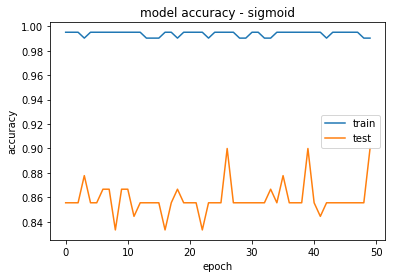

In [93]:
plt.plot(model_perf_sig.history['acc'])
plt.plot(model_perf_sig.history['val_acc'])
plt.title('model accuracy - sigmoid')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='mideel left')
plt.show()

In [92]:
model2 = Sequential()
model2.add(InputLayer((7*7*512,)))
model2.add(Dense(units=1024,activation='relu'))
model2.add(Dense(3,activation='softmax'))
model2.summary()
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_perf_relu = model2.fit(train,class_train,epochs=50,validation_data=(test,class_test))
print(model_perf_relu.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 90 samples
Epoch 1/50
208/208 [==============================] - 5s 23ms/step - loss: 1.0811 - acc: 0.5865 - val_loss: 0.6401 - val_acc: 0.7333
Epoch 2/50
208/208 [==============================] - 3s 14ms/step - loss: 0.3224 - acc: 0.8702 - val_loss: 0.5227 - val_acc: 0.7000
Epoch 3/50
208/208 [==============================] - 3s 15ms/step - loss: 0.1372 - acc: 0.9615 - val_loss: 0.4454 - val_acc: 0.8333
Epoch 4/50
208/208 [==============================] - 3s 15ms/step - loss: 0.0677 

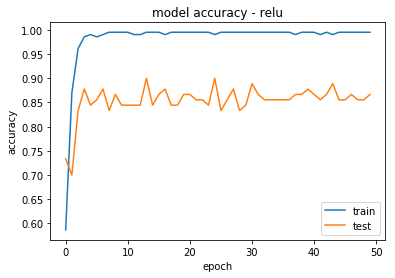

In [94]:
plt.plot(model_perf_relu.history['acc'])
plt.plot(model_perf_relu.history['val_acc'])
plt.title('model accuracy - relu')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [97]:
predictions_sig = model.predict_classes(img_test)
predictions_relu = model.predict_classes(img_test)

In [101]:
print("The screen time of JERRY in test set is (using sigmoid activation)", predictions_sig[predictions==1].shape[0], "seconds")
print("The screen time of TOM in test set is (using sigmoid activation)", predictions_sig[predictions==2].shape[0], "seconds")

The screen time of JERRY in test set is (using sigmoid activation) 18 seconds
The screen time of TOM in test set is (using sigmoid activation) 44 seconds


In [102]:
print("The screen time of JERRY in test set is (using relu activation)", predictions_relu[predictions==1].shape[0], "seconds")
print("The screen time of TOM in test set is (using relu activation)", predictions_relu[predictions==2].shape[0], "seconds")

The screen time of JERRY in test set is (using relu activation) 18 seconds
The screen time of TOM in test set is (using relu activation) 44 seconds
